<a href="https://colab.research.google.com/github/rj555/era-v4-session-4/blob/main/ERA_Session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [36]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? False


CODE BLOCK: 3

In [37]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [38]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

CODE BLOCK: 5

In [39]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

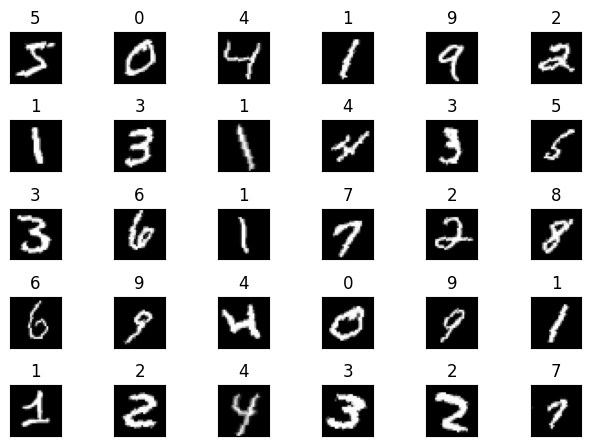

In [40]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(30):
  plt.subplot(5,6,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [41]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3) #output=26x26x4
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3) #o/p=24x24x8 => MaxPool => 12x12x8
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3) #o/p=10x10x16
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3) #o/p=8x8x32 => MaxPool => 4x4x32
        self.fc1 = nn.Linear(512, 30)
        self.fc2 = nn.Linear(30, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x), 2)
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(-1, 512)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [42]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [43]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


CODE BLOCK: 10

In [44]:
device = torch.device("cuda" if cuda else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1) #step_size=15, gamma=0.1
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.2793 Batch_id=468 Accuracy=72.92: 100%|██████████| 469/469 [00:38<00:00, 12.33it/s]


Test set: Average loss: 0.0012, Accuracy: 57150/60000 (95.25%)

Epoch 2


Train: Loss=0.1856 Batch_id=468 Accuracy=96.27: 100%|██████████| 469/469 [00:33<00:00, 14.02it/s]


Test set: Average loss: 0.0007, Accuracy: 58433/60000 (97.39%)

Epoch 3


Train: Loss=0.1829 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:40<00:00, 11.53it/s]


Test set: Average loss: 0.0005, Accuracy: 58691/60000 (97.82%)

Epoch 4


Train: Loss=0.1775 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:35<00:00, 13.32it/s]


Test set: Average loss: 0.0005, Accuracy: 58848/60000 (98.08%)

Epoch 5


Train: Loss=0.1821 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:34<00:00, 13.78it/s]


Test set: Average loss: 0.0005, Accuracy: 58776/60000 (97.96%)

Epoch 6


Train: Loss=0.1605 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:35<00:00, 13.34it/s]


Test set: Average loss: 0.0003, Accuracy: 59142/60000 (98.57%)

Epoch 7


Train: Loss=0.1568 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:35<00:00, 13.32it/s]


Test set: Average loss: 0.0003, Accuracy: 59192/60000 (98.65%)

Epoch 8


Train: Loss=0.1467 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:34<00:00, 13.45it/s]


Test set: Average loss: 0.0003, Accuracy: 59197/60000 (98.66%)

Epoch 9


Train: Loss=0.1561 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:34<00:00, 13.41it/s]


Test set: Average loss: 0.0003, Accuracy: 59205/60000 (98.67%)

Epoch 10


Train: Loss=0.1802 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:34<00:00, 13.55it/s]


Test set: Average loss: 0.0003, Accuracy: 59252/60000 (98.75%)

Epoch 11


Train: Loss=0.1590 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:35<00:00, 13.30it/s]


Test set: Average loss: 0.0003, Accuracy: 59279/60000 (98.80%)

Epoch 12


Train: Loss=0.1714 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:34<00:00, 13.73it/s]


Test set: Average loss: 0.0003, Accuracy: 59249/60000 (98.75%)

Epoch 13


Train: Loss=0.1491 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:35<00:00, 13.24it/s]


Test set: Average loss: 0.0003, Accuracy: 59280/60000 (98.80%)

Epoch 14


Train: Loss=0.1612 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:33<00:00, 13.83it/s]


Test set: Average loss: 0.0003, Accuracy: 59246/60000 (98.74%)

Epoch 15


Train: Loss=0.1591 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:35<00:00, 13.38it/s]


Test set: Average loss: 0.0003, Accuracy: 59266/60000 (98.78%)

Epoch 16


Train: Loss=0.1813 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:33<00:00, 13.82it/s]


Test set: Average loss: 0.0003, Accuracy: 59259/60000 (98.77%)

Epoch 17


Train: Loss=0.1636 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:35<00:00, 13.24it/s]


Test set: Average loss: 0.0003, Accuracy: 59289/60000 (98.81%)

Epoch 18


Train: Loss=0.1886 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:34<00:00, 13.59it/s]


Test set: Average loss: 0.0003, Accuracy: 59246/60000 (98.74%)

Epoch 19


Train: Loss=0.1814 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]


Test set: Average loss: 0.0003, Accuracy: 59306/60000 (98.84%)

Epoch 20


Train: Loss=0.1661 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:35<00:00, 13.28it/s]


Test set: Average loss: 0.0003, Accuracy: 59263/60000 (98.77%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

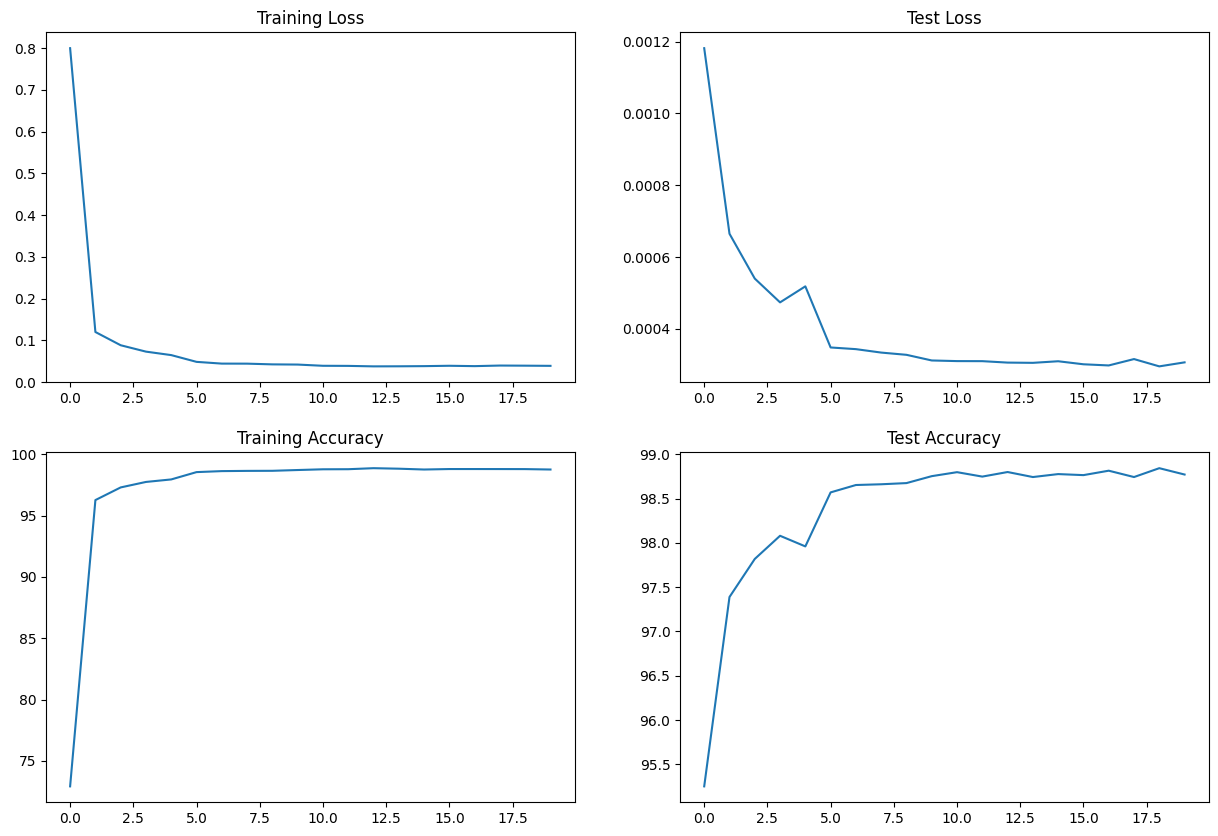

In [45]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [46]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              40
            Conv2d-2            [-1, 8, 24, 24]             296
            Conv2d-3           [-1, 16, 10, 10]           1,168
            Conv2d-4             [-1, 32, 8, 8]           4,640
            Linear-5                   [-1, 30]          15,390
            Linear-6                   [-1, 10]             310
Total params: 21,844
Trainable params: 21,844
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.08
Estimated Total Size (MB): 0.17
----------------------------------------------------------------
